In [13]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
import time
import json
import requests as reqs
from altair import Row, Column, Chart, Text, Scale, Color
import pandas as pd
import csv
from itertools import islice
import ast
import numpy as np
import json
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import re

from os import path
from PIL import Image
import os

from wordcloud import WordCloud, STOPWORDS

In [14]:
class Video:
    def __init__(self, idx, title, description, date, channelID, channel, categoryID, tags):
        self.idx = idx
        self.title = title
        self.description = description
        self.date = date
        self.channelID = channelID
        self.channel = channel
        self.categoryID = categoryID
        self.tags = tags
    def asList(self):
        return [
            self.idx, 
            self.title,
            self.description,
            self.date,
            self.channelID,
            self.channel,
            self.categoryID,
            self.tags
        ]
    
    
def get_data(totalVideo, perPage, channelID, youtubeAPIKEY):

    driver = webdriver.Chrome('/Users/aprilian/Downloads/chromedriver')
    driver.get("https://www.youtube.com/channel/"+channelID+"/videos?view=15&flow=grid")

    maxIterate = int(totalVideo/perPage)

    elem = driver.find_element_by_tag_name('html')
    for i in range(0,maxIterate):
        elem.send_keys(Keys.END)
        time.sleep(5)
        
    html = driver.page_source
    soup = BeautifulSoup(html)
    
    videos = []
    videoList = []
    for tag in soup.find_all("a", {'id':['video-title']}, href=True):
        url = tag['href']
        videoID = remove_prefix(url, '/watch?v=')
        video = get_video_detail(youtubeAPIKEY, videoID)
        videos.append(video)
        videoList.append(video.asList())
        
    with open('My-Youtube-Data.csv', 'a') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(videoList)
    csvFile.close()
    
    return videos
        
def get_video_detail(youtubeAPIKEY, videoID):
    response = reqs.get('https://www.googleapis.com/youtube/v3/videos?id='+videoID+'&key='+youtubeAPIKEY+'&part=snippet,contentDetails,statistics,status&hl=id')
    response_dict = json.loads(response.text)

    item = response_dict['items'][0]
    snippet = item['snippet']
    vid_id = item['id']
    vid_title = snippet['title']
    vid_date = snippet['publishedAt']
    vid_desc = snippet['description']
    vid_channelID = snippet['channelId']
    vid_channel = snippet['channelTitle']
    vid_categoryId = snippet['categoryId']
    vid_tags = snippet.get('tags')
    
    return Video(vid_id, vid_title, vid_desc, vid_date, vid_channelID, vid_channel, vid_categoryId, vid_tags)
    
    
def remove_prefix(text, prefix):
    if text.startswith(prefix): 
         text = text.replace(prefix, "", 1)
    return text

def result_by_title(videos, youtubeAPIKEY):
    
    text = ''
    counts = dict()
    for vid in videos:
        title = re.sub('\W+',' ', vid.title.lower())
        title = ' '.join( [w for w in title.split() if len(w)>1] )
        title = title.split()
        title = [word for word in title if word not in get_stop_words('en')]
        title = [word for word in title if word not in get_stop_words('id')]
        
        text += ' '.join(title)
        
        for t in title:
            counts[t] = counts.get(t, 0) + 1
            
    getWordCloud(text)
    
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    words = dict()
    for c in counts:
        words[c[0]] = c[1]
        
    
    MAX_RESULTS = 18
    words = {k: words[k] for k in list(words.keys())[:MAX_RESULTS]} 
        
    #change dictionary into dataframe 
    print("======== Title Most Likely ========")
    plt.figure(figsize=(10,10)) 
    dfY = pd.Series(words, name='Title')
    
    #show data as chart
    ax = dfY.plot.barh(x='lab', y='val', rot=0)
    plt.show()
    

def result_by_category(videos, youtubeAPIKEY):
    counts = dict()
    for vid in videos:
        counts[vid.categoryID] = counts.get(vid.categoryID, 0) + 1
        
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    categories = dict()
    for r in counts:
        response = reqs.get('https://www.googleapis.com/youtube/v3/videoCategories?id='+r[0]+'&key='+youtubeAPIKEY+'&part=snippet&hl=id')
        response_dict = json.loads(response.text)
        category = response_dict['items'][0]['snippet']['title']
        categories[category] = r[1]

    #change dictionary into dataframe 
    print("======== Category Most Likely ========")
    plt.figure(figsize=(10,10))
    dfX = pd.Series(categories, name='Category')
    
    #show data as chart
    ax = dfX.plot.barh(x='lab', y='val', rot=0) 
    plt.show()
        
    #return categories



def result_by_channel(videos):
    counts = dict()
    for vid in videos:
        counts[vid.channel] = counts.get(vid.channel, 0) + 1
        
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    channels = dict()
    for c in counts:
        channels[c[0]] = c[1]
        
    
    MAX_RESULTS = 18
    channels = {k: channels[k] for k in list(channels.keys())[:MAX_RESULTS]} 
        
    #change dictionary into dataframe 
    print("======== Channel Most Likely ========")
    plt.figure(figsize=(10,10))
    dfY = pd.Series(channels, name='Channel')
    
    #show data as chart
    ax = dfY.plot.barh(x='lab', y='val', rot=0) 
    plt.show()

    
    #return channels


def result_by_tag(videos):
    text = ''
    counts = dict()
    for vid in videos:

        tag = vid.tags
        if len(tag) > 0:
            tag = ast.literal_eval(tag)
            for t in tag:
                #print(t)
                t = t.lower()
                counts[t] = counts.get(t, 0) + 1
                text += ''.join(t)
                
                #tList = t.split()
                #for t1 in tList: 
                    #print(t1)
                    #counts[t1] = counts.get(t1, 0) + 1
                    #text += ''.join(t1)
                
     
    getWordCloud(text)
                
    
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
        
    tags = dict()
    for t in counts:
        tags[t[0]] = t[1]
        
    
    MAX_RESULTS = 20
    tags = {k: tags[k] for k in list(tags.keys())[:MAX_RESULTS]} 
        
    #change dictionary into dataframe 
    print("======== Tags Most Likely ========")
    plt.figure(figsize=(10,10)) 
    dfY = pd.Series(tags, name='Tags')
    
    #show data as chart
    ax = dfY.plot.barh(x='lab', y='val', rot=2)
    plt.show()

    #return tags
    

def loadCSVData():
    with open('My-Youtube-Data.csv', 'r') as readFile:
        reader = csv.reader(readFile)
        data = list(reader)
    videos = []
    for v in data:
        videos.append(Video(v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7]))
    return videos


def getWordCloud(text):
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    
    
    filtered_words = list(filter(lambda word: word not in getStopwords(), text))
    
    # read the mask image
    #alice_mask = np.array(Image.open(path.join(d, "owl.png")))

    stopwords = getStopwords()

    wc = WordCloud(background_color="white", max_words=2000,
                   stopwords=stopwords, contour_width=3, contour_color='steelblue')

    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, "result.png"))

    # show
    plt.figure(figsize=(20,20)) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    
def getStopwords():
    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["official", "di"])
    return stopwords



starting and getting data...
processing data...


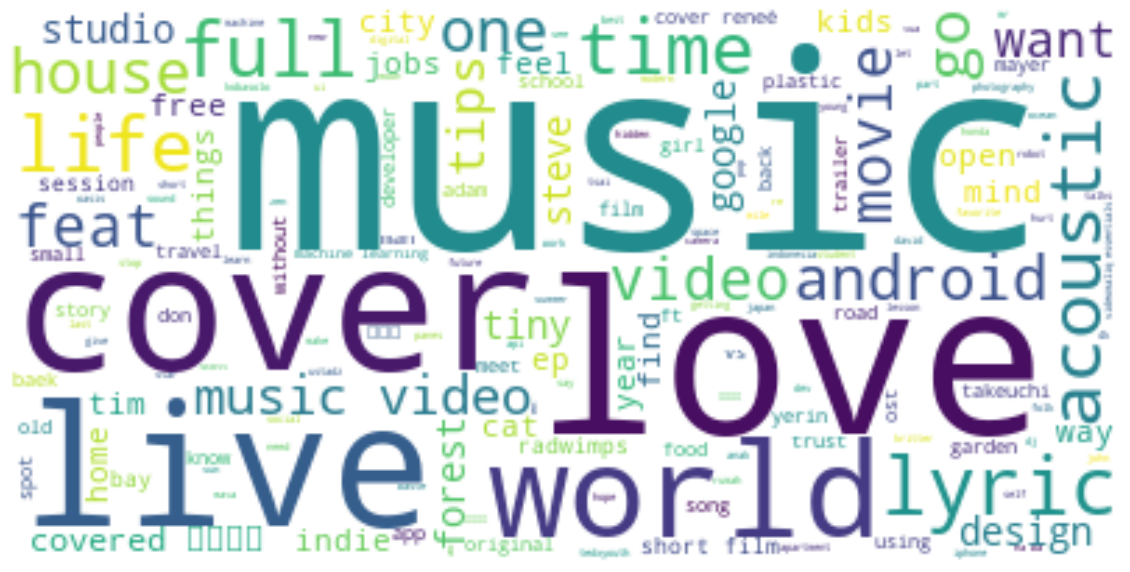

======== Title Most Likely ========


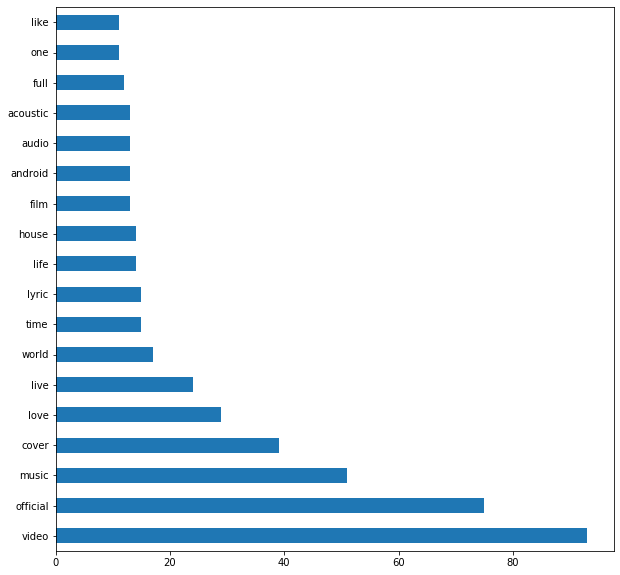

======== Category Most Likely ========


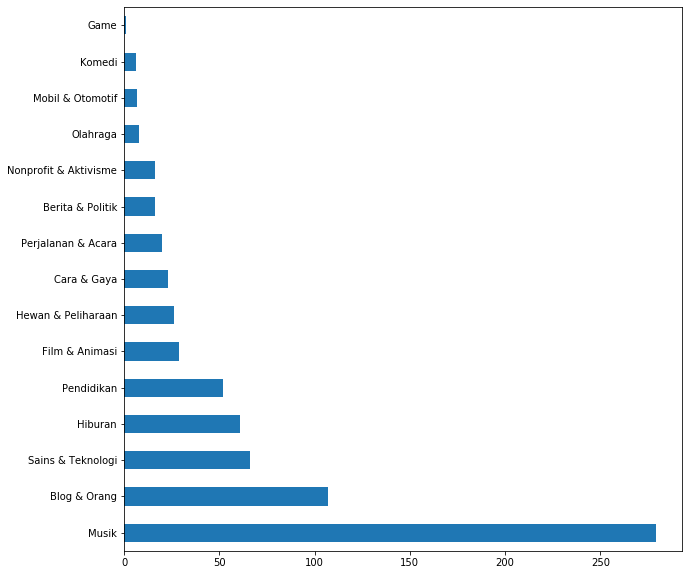

======== Channel Most Likely ========


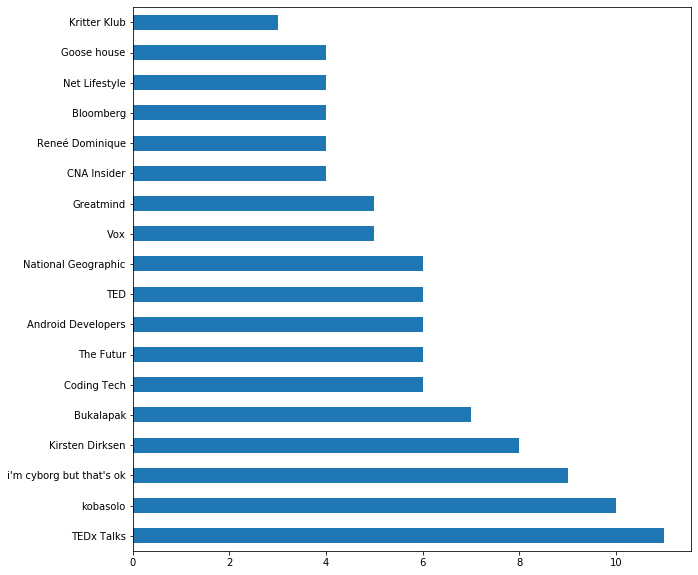

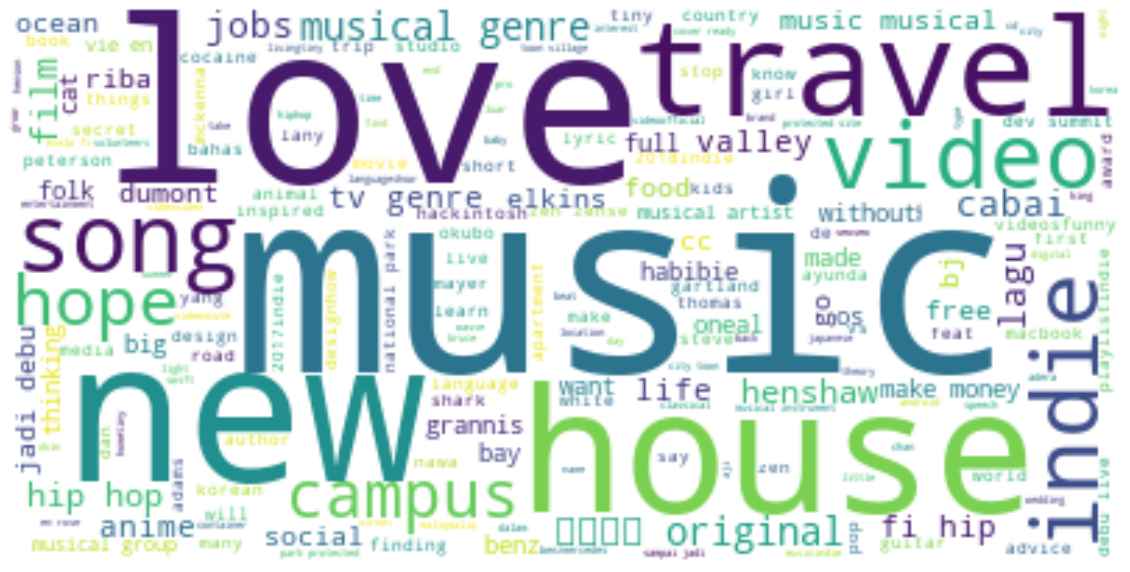

======== Tags Most Likely ========


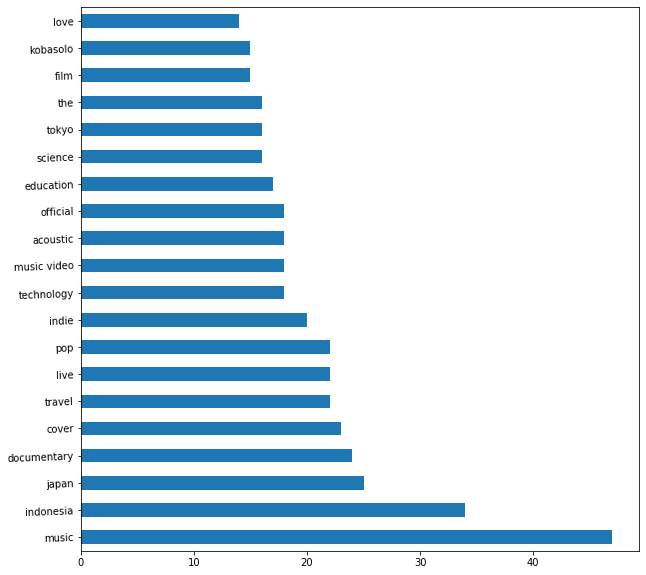

finished...


In [21]:
youtubeAPIKEY = '[YOUR_YOUTUBE_API_KEY]'
channelID = '[YOUR_CHANNEL_ID]'
totalVideo = 1000
perPage = 30

print("starting and getting data...")

#getting data from Internet, but if you have your local data (CSV file command code on below)
#videos = get_data(totalVideo, perPage, channelID, youtubeAPIKEY)
#load data from local file (CSV)
videos = loadCSVData()

print("processing data...")

result_by_title(videos, youtubeAPIKEY)

result_by_category(videos, youtubeAPIKEY)

result_by_channel(videos)

result_by_tag(videos)

print("finished...")